# Illegal Mining Dection Notebook <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2), 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)

This notebook uses changes in NDVI to identify vegetation change. 
The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral parameters in each of those time periods. 
Significant reductions in vegetation are coincident with land change. 
In some cases these changes could be deforestation. 
Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. 
In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.


## Description
The notebook demonstrates how to:

1. Load data for a given location and time period
2. Calculate the vegetation change using NDVI
3. Compare the water extent for two time periods
4. Combine all plot to show illegal mining area

***

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
import geopandas as gpd
from matplotlib.cm import RdYlGn
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from odc.algo import reshape_for_geomedian
from datacube.utils import geometry

sys.path.append('../Scripts')

from odc.algo import to_f32, from_float, xr_geomedian

from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster
from deafrica_datahandling import load_ard, mostcommon_crs, wofs_fuser, calc_geomedian
from deafrica_plotting import display_map, map_shapefile, rgb
from deafrica_spatialtools import xr_rasterize

In [2]:
dc = datacube.Datacube(app='illegal_mining')
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:43393 Dashboard: /user/nanaboamah/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [5]:
# Select an analysis region 
# Consider using Cloud Statistics notebook to find clear scenes

# longitude = -2.0174
# latitude = 6.2504
# buffer = 0.1

# # Combine central lat,lon with buffer to get area of interest
# lat_range = (latitude-buffer, latitude+buffer)
# lon_range = (longitude-buffer, longitude+buffer)


vector_file = "../Supplementary_data/Mining/Apam_forest.shp"


if vector_file:
    # read shapefile into a GeoDataFrame
    gdf = gpd.read_file(vector_file)

    # Covert all of the shapes into a datacube geometry
    geom = geometry.Geometry(gdf.unary_union, gdf.crs)

    
else:
    
    lat_range = (6.370517, 6.287974)
    lon_range = (-1.907504, -1.832074)

    


# lat_range = (6.259470, 6.107825)
# lon_range = (-2.093751, -1.905539)


In [4]:
## The code below renders a map that can be used to orient yourself with the region.
if vector_file:
    map_shapefile(gdf, attribute=gdf.columns[0])
else:
    display_map(lon_range, lat_range)
    

Label(value='')

Map(center=[6.328635468846285, -1.8708615021743045], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## <span id="define_analysis_params">Define Analysis Parameters [&#9652;](#top)</span>  

In [19]:
# Select the baseline time period (start and end)
# baseline_time_period = '2013'

# # Select the analysis time period (start and end)
# analysis_time_period = '2019'

time = ('2017-01-01', '2019-12-31')

# Set the date to separate the data into two samples for comparison
time_baseline = '2018-12-01'

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>  

In [20]:
#Create a query object
query = {
    'group_by': 'solar_day',
    'resolution': (-30, 30),
    'align': (15, 15),
}

if vector_file:
    query["geopolygon"] = geom
else:
    query["x"] = lon_range
    query["y"] = lat_range



products = ["s2_l2a"]
# find the right crs for the location
crs = mostcommon_crs(dc=dc, product='s2_l2a', query=query)

query['time'] = time
baseline_ds = load_ard(dc=dc, products=products, output_crs=crs, dask_chunks={'time': 1, 'x': 2000, 'y': 2000},measurements = ["red", "green", "blue", "nir"],  **query)

# query['time'] = (analysis_time_period)
# analysis_ds = load_ard(dc=dc, products=products, output_crs=crs, min_gooddata=0.70, **query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Returning 193 time steps as a dask array


In [21]:
#reshape the data to suit the geomedian function
da = reshape_for_geomedian(baseline_ds)

#Group the data by year and map the geomedian function 
da_annual_geomedian = da.groupby("time.year").map(
                        calc_geomedian, max_value=10000, min_value=0)

#convert back into a dataset
annual_geomedian = da_annual_geomedian.to_dataset(dim="band")

In [22]:
annual_geomedian

<xarray.Dataset>
Dimensions:  (x: 280, y: 283, year: 3)
Coordinates:
  * x        (x) float64 6.207e+05 6.207e+05 6.208e+05 ... 6.29e+05 6.291e+05
  * y        (y) float64 7.039e+05 7.039e+05 7.038e+05 ... 6.955e+05 6.954e+05
  * year     (year) int64 2017 2018 2019
Data variables:
    red      (y, x, year) float32 dask.array<chunksize=(283, 280, 1), meta=np.ndarray>
    green    (y, x, year) float32 dask.array<chunksize=(283, 280, 1), meta=np.ndarray>
    blue     (y, x, year) float32 dask.array<chunksize=(283, 280, 1), meta=np.ndarray>
    nir      (y, x, year) float32 dask.array<chunksize=(283, 280, 1), meta=np.ndarray>
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref
    nodata:        nan

In [23]:
annual_geomedian = calculate_indices(annual_geomedian, ['NDVI'], collection='c1')
annual_geomedian

<xarray.Dataset>
Dimensions:  (x: 280, y: 283, year: 3)
Coordinates:
  * x        (x) float64 6.207e+05 6.207e+05 6.208e+05 ... 6.29e+05 6.291e+05
  * y        (y) float64 7.039e+05 7.039e+05 7.038e+05 ... 6.955e+05 6.954e+05
  * year     (year) int64 2017 2018 2019
Data variables:
    red      (y, x, year) float32 dask.array<chunksize=(283, 280, 1), meta=np.ndarray>
    green    (y, x, year) float32 dask.array<chunksize=(283, 280, 1), meta=np.ndarray>
    blue     (y, x, year) float32 dask.array<chunksize=(283, 280, 1), meta=np.ndarray>
    nir      (y, x, year) float32 dask.array<chunksize=(283, 280, 1), meta=np.ndarray>
    NDVI     (y, x, year) float32 dask.array<chunksize=(283, 280, 1), meta=np.ndarray>
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref
    nodata:        nan

## <span id="anomalies">Calculate Anomaly Product [&#9652;](#top)</span>  

In [24]:
annual_geomedian = annual_geomedian.compute()

In [25]:
# Convert the mangrove polygon to a raster that matches our imagery data.
annual_geomedian_mask = xr_rasterize(gdf, annual_geomedian)

# Mask dataset to set pixels outside the polygon to `NaN`
ds_dataset_masked = annual_geomedian.where(annual_geomedian_mask)

Rasterizing to match xarray.DataArray dimensions (283, 280)


In [27]:
#select two different years to compute the difference
baseline_year =  ds_dataset_masked.sel(year=2017)
analysis_year =  ds_dataset_masked.sel(year=2019)

In [28]:
parameter_anomaly = analysis_year.NDVI - baseline_year.NDVI

sig_deforestation = parameter_anomaly < -0.2
sig_deforestation['name'] = "Deforestation"

# Determine areas with significant afforestations (positive difference)
sig_afforestation = parameter_anomaly > 0.2
sig_afforestation['name'] = "Afforestation"

## Show Baseline RGB, Analysis RGB and Anomaly Products

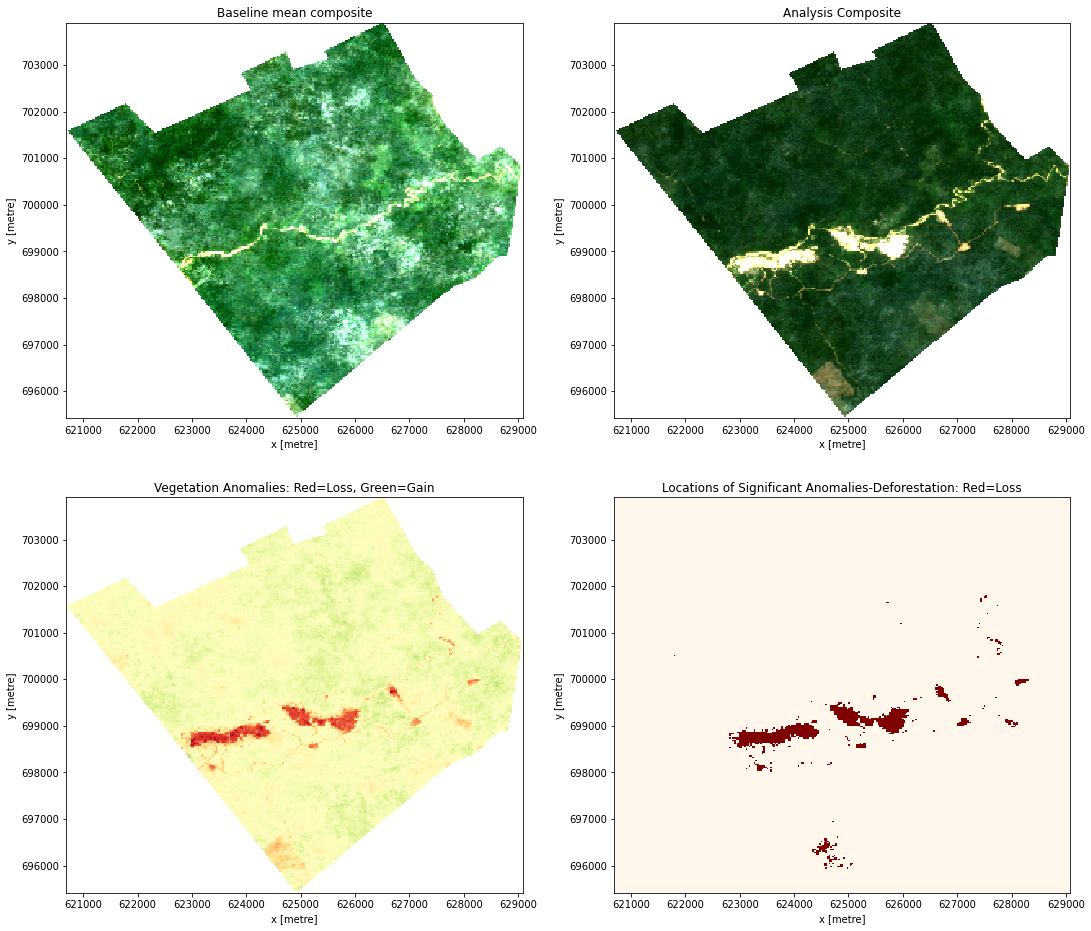

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(18, 16))
baseline_year[['red', 'green', 'blue']].to_array().plot.imshow(ax=ax[0,0], robust=True)
analysis_year[['red', 'green', 'blue']].to_array().plot.imshow(ax=ax[0,1], robust=True)
parameter_anomaly.plot(cmap='RdYlGn', ax=ax[1,0], add_colorbar=False)
sig_deforestation.plot(cmap='OrRd', ax=ax[1,1],  add_colorbar=False)
ax[0,0].set_title('Baseline mean composite')
ax[0,1].set_title('Analysis Composite')
ax[1,0].set_title('Vegetation Anomalies: Red=Loss, Green=Gain')
ax[1,1].set_title('Locations of Significant Anomalies-Deforestation: Red=Loss')
plt.show()


## Calculate Pixel Counts within Thresholds

In [15]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

In [17]:
total_pixels = analysis_year.NDVI.count(dim=['x', 'y']).values
total_deforestation = sig_deforestation.where(sig_deforestation==True).count(dim=['x', 'y']).values

total_forest_area = total_pixels * area_per_pixel
deforestation_area = total_deforestation * area_per_pixel
percentage_deforestation = (total_deforestation/total_pixels) * 100


print(f"{total_forest_area:.2f} of Total Area")
print(f"{deforestation_area:.2f} area deforestation")
print(f"{percentage_deforestation:.2f}% of pixels likely underwent deforestation")

36.25 of Total Area
1.19 area deforestation
3.29% of pixels likely underwent deforestation


# Determine the change in water area of the Two year

In [18]:
query['time'] = ('2013')
ds_wofs_1 = dc.load(product=["ga_ls8c_wofs_2"],
             output_crs=crs,
             fuse_func=wofs_fuser,
             **query
            )

query['time'] = ('2019')
ds_wofs_2 = dc.load(product=["ga_ls8c_wofs_2"],
             output_crs=crs,
             fuse_func=wofs_fuser,
             **query
            )

TypeError: result() takes 2 positional arguments but 3 were given

In [16]:
ds_water_baseline = ds_wofs_1.water.isin([128])
ds_water_analysis = ds_wofs_2.water.isin([128])

In [17]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

In [18]:
ds_water_area_baseline = ds_water_baseline.sum(dim=['x', 'y']) * area_per_pixel
ds_water_area_analysis = ds_water_analysis.sum(dim=['x', 'y']) * area_per_pixel

In [19]:
baseline_max_water, analysis_max_water = max(ds_water_area_baseline) ,  max(ds_water_area_analysis)

In [20]:
max_water_baseline = ds_water_baseline.sel(time=baseline_max_water.time.values)
max_water_analysis = ds_water_analysis.sel(time=analysis_max_water.time.values)

In [21]:
#The dataset array is transform to 1 and 0 using the `astype(int)` function.
change = max_water_analysis.astype(int) - max_water_baseline.astype(int)

#The various scenarios are extracted from the `change` variable for the two years
#Water gain  is 1
water_appeared = change.where(change == 1)

#Permanent water = 0
permanent_water = change.where((change == 0) & (max_water_analysis == 1))

#Water loss = -1
water_disappeared = change.where(change == -1)

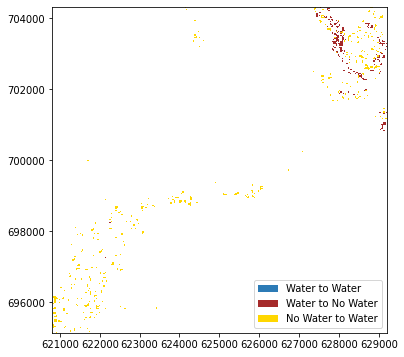

In [22]:
water_appeared_color = 'Gold'
water_disappeared_color = 'Brown'
stable_color = '#2c7bb6'
vegetation_loss = 'Red'
vegetation_gain = 'Green'

plt.figure(figsize=(6, 6))

water_appeared.plot.imshow(cmap=ListedColormap([water_appeared_color]), add_colorbar=False, add_labels=False)
water_disappeared.plot.imshow(cmap=ListedColormap([water_disappeared_color]), add_colorbar=False, add_labels=False)

plt.legend(
        [ Patch(facecolor=stable_color), 
         Patch(facecolor=water_disappeared_color), Patch(facecolor=water_appeared_color)], 
        ['Water to Water', 'Water to No Water' ,
         'No Water to Water',  'No Water to No water'],
        loc = 'lower right'
    )

# Combine both plots to determine mining areas

Text(0.5, 1.0, 'Mining Areas')

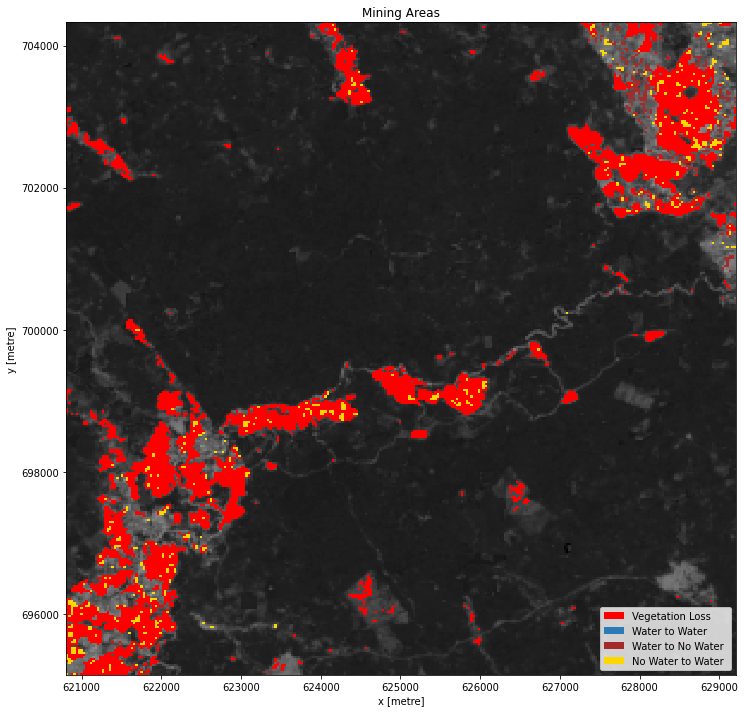

In [23]:
plt.figure(figsize=(12, 12))

analysis_year.NDVI.plot.imshow(cmap='Greys', add_colorbar=False)
sig_deforestation.where(sig_deforestation==True).plot.imshow(cmap=ListedColormap([vegetation_loss]), add_colorbar=False)
water_appeared.plot.imshow(cmap=ListedColormap([water_appeared_color]), add_colorbar=False, add_labels=False)
water_disappeared.plot.imshow(cmap=ListedColormap([water_disappeared_color]), add_colorbar=False, add_labels=False)

plt.legend(
        [Patch(facecolor=vegetation_loss), Patch(facecolor=stable_color), 
         Patch(facecolor=water_disappeared_color), Patch(facecolor=water_appeared_color)], 
        ['Vegetation Loss','Water to Water', 'Water to No Water ' ,
         'No Water to Water',  'No Water to No water'],
        loc = 'lower right'
    )

plt.title('Mining Areas')

## Next steps


You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.



***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** July 2020

**Compatible datacube version:** 

In [24]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)